In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from IPython.display import display

import os, random

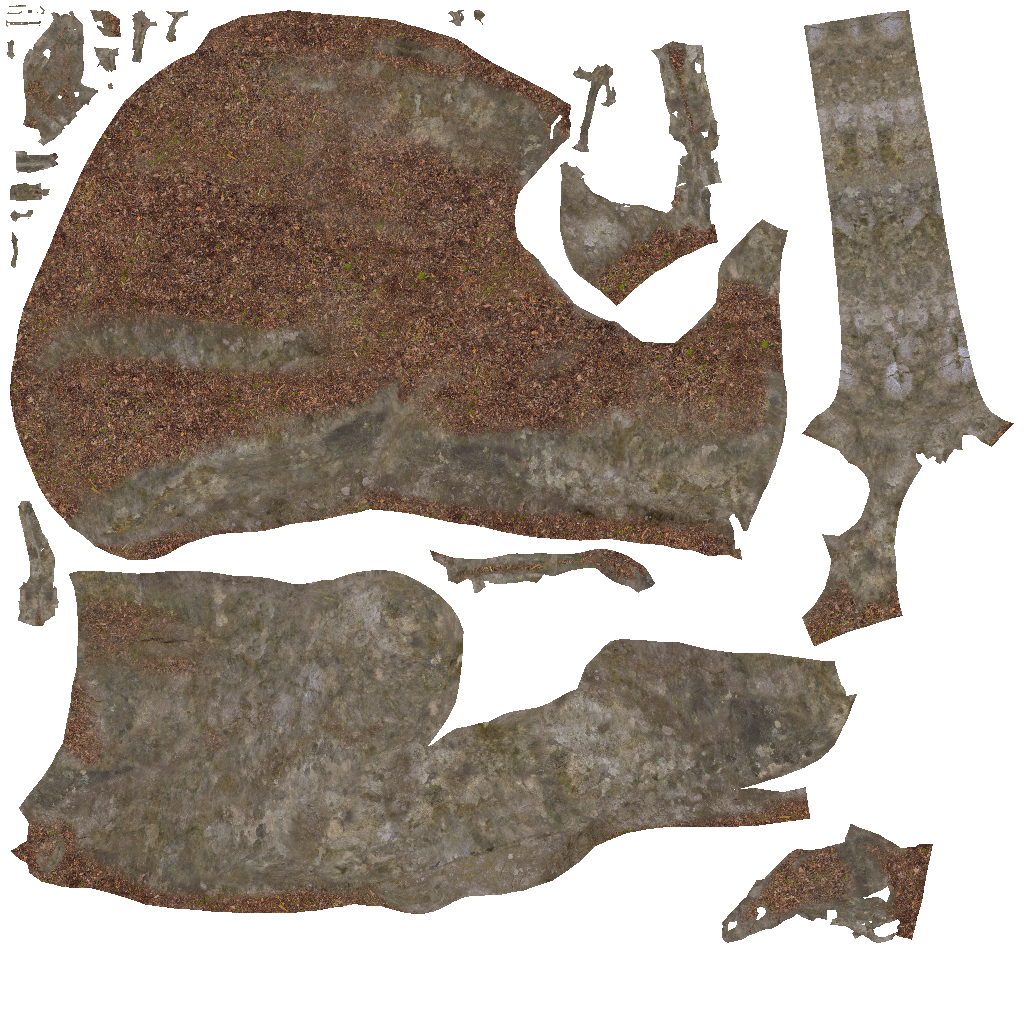

[[[107 100  85   0]
  [110 101  87   0]
  [112 102  85   0]
  ..., 
  [119 108  97   0]
  [120 108  97   0]
  [119 107  97   0]]

 [[108 100  86   0]
  [110 100  87   0]
  [112 101  86   0]
  ..., 
  [119 107  96   0]
  [119 108  97   0]
  [119 107  97   0]]

 [[105  98  87   0]
  [110 101  88   0]
  [113 103  90   0]
  ..., 
  [120 107  97   0]
  [119 107  97   0]
  [119 108  97   0]]

 ..., 
 [[100  92  79   0]
  [101  92  80   0]
  [101  92  80   0]
  ..., 
  [131 122 108   0]
  [130 122 108   0]
  [130 122 108   0]]

 [[101  92  80   0]
  [101  91  80   0]
  [101  91  80   0]
  ..., 
  [131 122 108   0]
  [131 122 108   0]
  [130 122 107   0]]

 [[101  92  79   0]
  [100  92  80   0]
  [101  92  80   0]
  ..., 
  [131 123 108   0]
  [131 122 107   0]
  [131 122 108   0]]]


In [5]:
im = Image.open('data/Data_2017_03_31/Data/Rock/Mesh_000000/_Shared/Mesh_000000_HD_BC.tga')
display(im)
print(np.array(im))

In [14]:
date_dir = 'data/Data_2017_03_31/'

def scan_lighted_delighted(date_dir):
    '''
    date_dir: i.e. Data_2017_03_31/ WITH THE FORWARD SLASH
    returns:
        delighted_dirs: maps mesh (Mesh_000000) to directory of delighted data 
            ('data/Data_2017_03_31/Data/Rock/Mesh_000000/_Shared/')
        lighted_dirs: a list of (type, mesh, version, lighted_directory_path) tuples, 
            i.e. (Rock, Mesh_000000, V_000014, 'data/Data_2017_03_31/Data/Rock/Mesh_000000/V_000014/')
    '''
    data_dir = date_dir + 'Data/'
    delighted_dirs = {}
    lighted_dirs = []
    types = os.listdir(data_dir)
    for type in types:
        type_dir = data_dir + type + '/'
        meshes = [mesh for mesh in os.listdir(type_dir) if mesh.startswith('Mesh_')]
        for mesh in meshes:
            mesh_dir = type_dir + mesh + '/'
            delighted_dir = mesh_dir + '_Shared/'
            if mesh not in delighted_dirs:
                delighted_dirs[mesh] = delighted_dir
            delighted_dir = delighted_dirs[mesh]
            versions = [v for v in os.listdir(mesh_dir) if v.startswith('V_')]
            for version in versions:
                version_dir = mesh_dir + version + '/'
                lighted_dirs.append((type, mesh, version, version_dir))
    return delighted_dirs, lighted_dirs

lighted_dirs, delighted_dirs = scan_lighted_delighted(date_dir)

def zero_rgb(im):
    '''
    takes in a r, g, b, a array and zero out rgb if a = 0
    '''
    alpha = im[:, :, 3:] > 0
    return im * alpha

In [3]:
def downsample_image(image, factor):
    return image.resize((image.width // factor, image.height // factor), Image.ANTIALIAS)

In [4]:
delighted_data = {}
for mesh, mesh_dir in delighted_dirs.items():
    mesh_im = Image.open(mesh_dir + '%s_HD_BC.tga' % mesh, 'r')
    mesh_array = zero_rgb(np.array(mesh_im))
    delighted_data[mesh] = mesh_array

In [5]:
lighted_data = []
pyramid_depth = 8
reduction_factor = 2
for t, mesh, v, mesh_dir in lighted_dirs:
    lit_file = '%s%s_%s_%s_Lit.tga' % (mesh_dir, t, mesh, v)
    if not os.path.exists(lit_file):
        continue
    mesh_im = Image.open(lit_file, 'r')
    meshes = [np.array(mesh_im)]
    for _ in range(pyramid_depth):
        mesh_im = downsample_image(mesh_im, reduction_factor)
        meshes.append(np.array(mesh_im))
    lighted_data.append((mesh, meshes))

In [10]:
class CNN:
    def __init__(self, n_in, pyramid_depth, reduction_factor):
        graph = tf.Graph()
        self.sess = tf.InteractiveSession(graph=graph)
        
        depths = [n_in // (reduction_factor ** depth) for depth in range(pyramid_depth + 1)]
            
        self.inputs = [tf.placeholder(tf.float32, shape=(1, depth, depth, 1)) for depth in depths]
        
        prev_layer = None
        for i, layer in reversed(list(enumerate(self.inputs))[1:]):
            filters = tf.get_variable('conv_%s' % (pyramid_depth - i), shape=(4, 4, 1, 1), initializer=tf.contrib.layers.xavier_initializer())
            conv_out = tf.nn.conv2d(layer, filters, strides=[1, 1, 1, 1], padding='SAME')
            sig_out = tf.nn.sigmoid(conv_out)
            if prev_layer is None:
                deconv_in = sig_out
            else:
                deconv_in = sig_out + prev_layer
            deconv_filters = tf.get_variable('deconv_%s' % (pyramid_depth - i), shape=(4, 4, 1, 1), initializer=tf.contrib.layers.xavier_initializer())
            out_dim = depths[i - 1]
            deconv_out = tf.nn.conv2d_transpose(deconv_in, deconv_filters, output_shape=[1, out_dim, out_dim, 1], strides=[1, reduction_factor, reduction_factor, 1], padding='SAME')
            prev_layer = deconv_out
        self.pred = tf.nn.relu(self.inputs[0] + prev_layer)
        self.true = tf.placeholder(tf.float32, shape=self.pred.get_shape())
        self.loss = tf.reduce_mean(tf.squared_difference(self.pred, self.true))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def fit_batch(self, inputs, output):
        for rgb in range(3):
            rgb_inputs = [x[:, :, rgb].reshape((1,) + x.shape[:2] + (1,)) for x in inputs]
            rgb_output = output[:, :, rgb].reshape(tf.get_shape(self.true))
            feed_dict = dict(zip(self.inputs, rgb_inputs))
            feed_dict[self.true] = rgb_output
            _, loss = self.sess.run((self.optimizer, self.loss), feed_dict=feed_dict)
        return loss
    
    def train(self, lighted_inputs, delighted_data, epochs, batch_size=1, display_step=5):
        random.shuffle(lighted_inputs)
        n_samples = len(lighted_inputs)
        mean_losses = []
        for epoch in range(epochs):
            total_iter = n_samples // batch_size
            total_loss = 0
            for i in range(total_iter):
                mesh, inputs = lighted_inputs[i * batch_size]
                loss = self.fit_batch(inputs, delighted_data[mesh])
                total_loss += loss
            mean_loss = total_loss / total_iter
            mean_losses.append(mean_loss)
            if (epoch + 1) % display_step == 0:
                print('epoch %s: loss=%.4f' % (epoch + 1, mean_loss))
                
    def fit_batch(self, inputs, output):
        for rgb in range(3):
            rgb_inputs = [x[:, :, rgb].reshape((1,) + x.shape[:2] + (1,)) for x in inputs]
            rgb_output = output[:, :, rgb].reshape((1, 1024, 1024, 1))
            feed_dict = dict(zip(self.inputs, rgb_inputs))
            feed_dict[self.true] = rgb_output
            _, loss = self.sess.run((self.optimizer, self.loss), feed_dict=feed_dict)
        return loss
    
    def predict(self, inputs):
        output = np.zeros(inputs[0].shape, dtype=np.uint8)
        for rgb in range(3):
            rgb_inputs = [x[:, :, rgb].reshape((1,) + x.shape[:2] + (1,)) for x in inputs]
            feed_dict = dict(zip(self.inputs, rgb_inputs))
            pred = self.sess.run(self.pred, feed_dict=feed_dict)
            output[:, :, rgb] = pred.reshape((1024, 1024)).astype(np.uint8)
        output[:, :, -1] = inputs[0][:, :, -1]
        output[output < 0] = 0
        output[output > 255] = 255
        return output

In [11]:
cnn = CNN(1024, pyramid_depth, reduction_factor)
cnn.train(lighted_data, delighted_data, 20, display_step=1)

epoch 1: loss=504.9789
epoch 2: loss=498.1967
epoch 3: loss=489.7569
epoch 4: loss=483.2343
epoch 5: loss=479.4939
epoch 6: loss=477.1004
epoch 7: loss=474.7953
epoch 8: loss=474.6147
epoch 9: loss=472.6138
epoch 10: loss=470.9131
epoch 11: loss=469.7101
epoch 12: loss=468.1280
epoch 13: loss=467.6331
epoch 14: loss=466.9174
epoch 15: loss=465.6776
epoch 16: loss=466.1043
epoch 17: loss=465.5190
epoch 18: loss=464.9716
epoch 19: loss=463.6084
epoch 20: loss=463.3575


In [41]:
input_label, inputs = lighted_data[50]
delighted = delighted_data[input_label]
# display(Image.fromarray(inputs[0]))
output = cnn.predict(inputs)
# display(Image.fromarray(output))
# Image.fromarray(delighted)
print(np.mean((zero_rgb(output) - inputs[0])** 2))
print(np.mean((zero_rgb(output) - delighted)** 2))
print(np.mean((inputs[0] - delighted)** 2))

21.8525886536
46.1004407406
47.27292943
